<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Generative adversarial networks</b></h3>



В этом домашнем задании вы обучите GAN генерировать лица людей и посмотрите на то, как можно оценивать качество генерации

In [1]:
!pip install -q torchsummary

In [17]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchsummary import summary
import torchvision
torchvision.disable_beta_transforms_warning()
from torchvision.transforms import v2 as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output
import time
%matplotlib inline

sns.set(style='darkgrid', font_scale=1.2)

## Часть 1. Подготовка данных (1 балл)

В качестве обучающей выборки возьмем часть датасета [Flickr Faces](https://github.com/NVlabs/ffhq-dataset), который содержит изображения лиц людей в высоком разрешении (1024х1024). Оригинальный датасет очень большой, поэтому мы возьмем его часть. Скачать датасет можно [здесь](https://www.kaggle.com/datasets/tommykamaz/faces-dataset-small?resource=download-directory) и  [здесь](https://drive.google.com/drive/folders/14H7LQWzd09SaM11oLfGtd455sWH2rmRW?usp=share_link)

Давайте загрузим наши изображения. Напишите функцию, которая строит DataLoader для изображений, при этом меняя их размер до нужного значения (размер 1024 слишком большой, поэтому мы рекомендуем взять размер 128 либо немного больше)

In [3]:
DATA_DIR = '/kaggle/input/faces-dataset-small/'

In [4]:
def get_dataloader(image_size, batch_size):
    """
    Builds dataloader for training data.
    Use tt.Compose and tt.Resize for transformations
    :param image_size: height and wdith of the image
    :param batch_size: batch_size of the dataloader
    :returns: DataLoader object
    """
    transform = tt.Compose(
        [
            tt.Resize((image_size, image_size)),
            tt.ToImageTensor(),
            tt.ConvertImageDtype(torch.float),
            tt.Normalize(
                [0.5, 0.5, 0.5],
                [0.5, 0.5, 0.5],
            ),
        ]
    )
    dataset = ImageFolder(root=DATA_DIR, transform=transform)
    loader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=os.cpu_count()
    )
    return loader

In [220]:
def denorm(img_tensors):
    return img_tensors * 0.5 + 0.5

def show_images(images, nmax=64, norm=True):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    if norm:
        ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))
    else:
        ax.imshow(make_grid(images.detach()[:nmax], nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

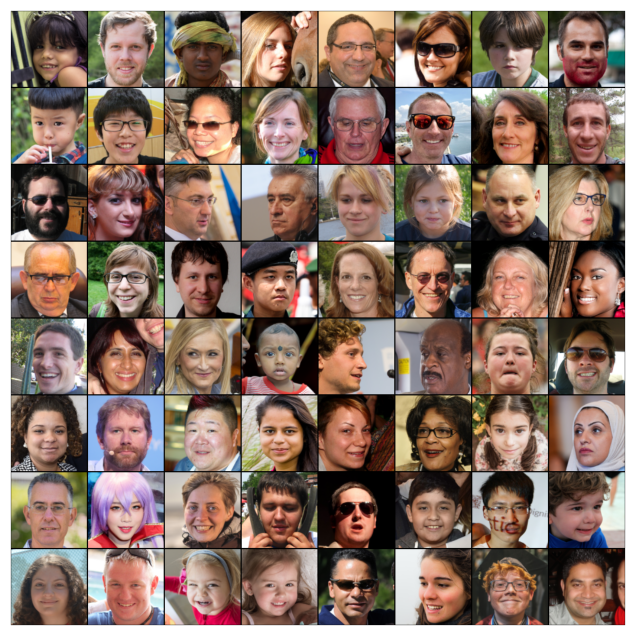

In [6]:
image_size = 128
batch_size = 64
loader = get_dataloader(image_size, batch_size)
show_batch(loader)

In [7]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [9]:
train_dl = DeviceDataLoader(loader, device)

## Часть 2. Построение и обучение модели (2 балла)

Сконструируйте генератор и дискриминатор. Помните, что:
* дискриминатор принимает на вход изображение (тензор размера `3 x image_size x image_size`) и выдает вероятность того, что изображение настоящее (тензор размера 1)

* генератор принимает на вход тензор шумов размера `latent_size x 1 x 1` и генерирует изображение размера `3 x image_size x image_size`

В дискриминаторе и генераторе я добавил по дополнительному конволюционному слою (512 -> 1024 каналов в дискриминаторе, 1024 -> 512 в генераторе).

In [137]:
discriminator = nn.Sequential(
    # in: 3 x 128 x 128

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 64 x 64

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 32 x 32

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 16 x 16

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 8 x 8
    
    nn.Conv2d(512, 1024, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(1024),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(1024, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid()
)
discriminator = to_device(discriminator, device)

In [138]:
latent_size = 256

generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 1024, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(1024),
    nn.ReLU(True),
    # out: 1024 x 4 x 4
    
    nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 8 x 8

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 16 x 16

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 32 x 32

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 64 x 64

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 128 x 128
)

torch.Size([64, 3, 128, 128])


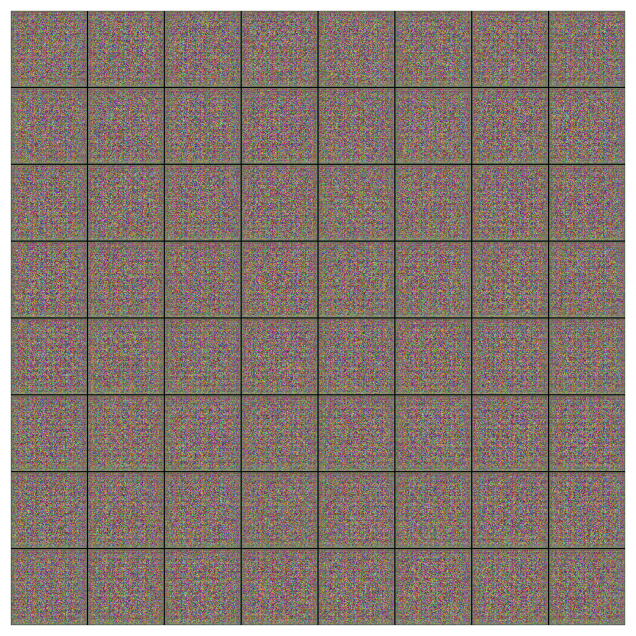

In [139]:
xb = torch.randn(batch_size, latent_size, 1, 1) 
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [140]:
generator = to_device(generator, device)

In [14]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [141]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

In [142]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

Перейдем теперь к обучению нашего GANа. Алгоритм обучения следующий:
1. Учим дискриминатор:
  * берем реальные изображения и присваиваем им метку 1
  * генерируем изображения генератором и присваиваем им метку 0
  * обучаем классификатор на два класса

2. Учим генератор:
  * генерируем изображения генератором и присваиваем им метку 0
  * предсказываем дискриминаторором, реальное это изображение или нет


В качестве функции потерь берем бинарную кросс-энтропию

In [103]:
def plot_outputs(
    last_imgs,
    epoch,
    n_epochs,
    losses,
    global_passed,
    time_mean,
    max_imgs=32
):
    clear_output(wait=True)
    fig, ax = plt.subplots(figsize=(10, 6.5))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(last_imgs[:max_imgs]), nrow=8).permute(1, 2, 0))

    plt.suptitle((
        f'Epochs: {epoch + 1} / {n_epochs}\n'
        f'[{"/" * (epoch + 1)}{"." * (n_epochs - epoch - 1)} ]\n'
        f'Time passed: {global_passed:.2f} s,  Per epoch: {time_mean:.2f} s,  '
        f'Estimated time left: {(n_epochs-epoch-1)*time_mean:.2f} s\n'
        f'Generator loss: {losses[0]:.4f}, Discriminator loss: {losses[1]:.4f}\n'
        f'Real score: {losses[2]:.4f}, Fake score: {losses[3]:.4f}'
        ),
        fontsize=14
    )
    plt.show()

После нескольких экспериментов понял, что дискрминатор очень сильно обгоняет генератор, поэтому немного усложнил ему жизнь с помощью soft labels (вместо метки 0 - [0, 0.1], 1 - [0.9, 1]), а также шаг обучения поставил для него в 3 раза меньше, чем у генератора.

In [143]:
def fit(model, criterion, epochs, lr, plot_outputs_fn, start_idx=1):
    model["discriminator"].train()
    model["generator"].train()
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Time
    global_start = time.time()
    epoch_times = []
    
    # Create optimizers
    optimizer = {
        "discriminator": torch.optim.Adam(model["discriminator"].parameters(), 
                                          lr=lr/3, betas=(0.5, 0.999)),
        "generator": torch.optim.Adam(model["generator"].parameters(),
                                      lr=lr, betas=(0.5, 0.999))
    }

    for epoch in range(epochs):
        epoch_start = time.time()
        
        loss_d_per_epoch = []
        loss_g_per_epoch = []
        real_score_per_epoch = []
        fake_score_per_epoch = []
        
        for real_images, _ in tqdm(
            train_dl,
            desc=f"Epoch {epoch + 1}",
            leave=True if epoch == epochs - 1 else False
        ):
            # Train discriminator
            # Clear discriminator gradients
            optimizer["discriminator"].zero_grad()

            # Pass real images through discriminator
            real_preds = model["discriminator"](real_images)
            # real_targets = torch.ones(real_images.size(0), 1, device=device)
            # Soft labels
            real_targets = torch.clamp(
                torch.randn(real_images.size(0), 1, device=device) * 0.05 + 0.95,
                min=0.9,
                max=1
            )
            real_loss = criterion["discriminator"](real_preds, real_targets)
            cur_real_score = torch.mean(real_preds).item()
            
            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)

            # Pass fake images through discriminator
            #fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
            fake_targets = torch.clamp(
                torch.randn(fake_images.size(0), 1, device=device) * 0.05 + 0.05,
                min=0,
                max=0.1
            )
            fake_preds = model["discriminator"](fake_images)
            fake_loss = criterion["discriminator"](fake_preds, fake_targets)
            cur_fake_score = torch.mean(fake_preds).item()

            real_score_per_epoch.append(cur_real_score)
            fake_score_per_epoch.append(cur_fake_score)

            # Update discriminator weights
            loss_d = real_loss + fake_loss
            loss_d.backward()
            optimizer["discriminator"].step()
            loss_d_per_epoch.append(loss_d.item())


            # Train generator
            # Clear generator gradients
            optimizer["generator"].zero_grad()
            
            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)
            
            # Try to fool the discriminator
            preds = model["discriminator"](fake_images)
            
            targets = torch.ones(batch_size, 1, device=device)
            loss_g = criterion["generator"](preds, targets)
            
            # Update generator weights
            loss_g.backward()
            optimizer["generator"].step()
            loss_g_per_epoch.append(loss_g.item())
            
        
        # Record losses & scores
        mean_g_epoch = np.mean(loss_g_per_epoch)
        mean_d_epoch = np.mean(loss_d_per_epoch)
        mean_real_epoch = np.mean(real_score_per_epoch)
        mean_fake_epoch = np.mean(fake_score_per_epoch)
        losses_g.append(mean_g_epoch)
        losses_d.append(mean_d_epoch)
        real_scores.append(mean_real_epoch)
        fake_scores.append(mean_fake_epoch)
        
        # Time
        epoch_end = time.time()
        global_passed = epoch_end - global_start
        epoch_times.append(epoch_end - epoch_start)
        time_mean = np.mean(epoch_times)
        
        # Plot generated images, time and losses
        plot_outputs_fn(
            fake_images.detach().cpu(),
            epoch,
            epochs,
            [mean_g_epoch, mean_d_epoch, mean_real_epoch, mean_fake_epoch],
            global_passed,
            time_mean
        )
    
        # Save generated images
        if epoch == epochs - 1:
            save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [144]:
summary(discriminator, (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           3,072
       BatchNorm2d-2           [-1, 64, 64, 64]             128
         LeakyReLU-3           [-1, 64, 64, 64]               0
            Conv2d-4          [-1, 128, 32, 32]         131,072
       BatchNorm2d-5          [-1, 128, 32, 32]             256
         LeakyReLU-6          [-1, 128, 32, 32]               0
            Conv2d-7          [-1, 256, 16, 16]         524,288
       BatchNorm2d-8          [-1, 256, 16, 16]             512
         LeakyReLU-9          [-1, 256, 16, 16]               0
           Conv2d-10            [-1, 512, 8, 8]       2,097,152
      BatchNorm2d-11            [-1, 512, 8, 8]           1,024
        LeakyReLU-12            [-1, 512, 8, 8]               0
           Conv2d-13           [-1, 1024, 4, 4]       8,388,608
      BatchNorm2d-14           [-1, 102

In [145]:
summary(generator, (latent_size, 1, 1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1           [-1, 1024, 4, 4]       4,194,304
       BatchNorm2d-2           [-1, 1024, 4, 4]           2,048
              ReLU-3           [-1, 1024, 4, 4]               0
   ConvTranspose2d-4            [-1, 512, 8, 8]       8,388,608
       BatchNorm2d-5            [-1, 512, 8, 8]           1,024
              ReLU-6            [-1, 512, 8, 8]               0
   ConvTranspose2d-7          [-1, 256, 16, 16]       2,097,152
       BatchNorm2d-8          [-1, 256, 16, 16]             512
              ReLU-9          [-1, 256, 16, 16]               0
  ConvTranspose2d-10          [-1, 128, 32, 32]         524,288
      BatchNorm2d-11          [-1, 128, 32, 32]             256
             ReLU-12          [-1, 128, 32, 32]               0
  ConvTranspose2d-13           [-1, 64, 64, 64]         131,072
      BatchNorm2d-14           [-1, 64,

In [146]:
model = {
    "discriminator": discriminator,
    "generator": generator
}

criterion = {
    "discriminator": nn.BCELoss(),
    "generator": nn.BCELoss()
}

lr = 3e-4 # для дискриминатора 1e-4 (в 3 раза меньше)
epochs = 100

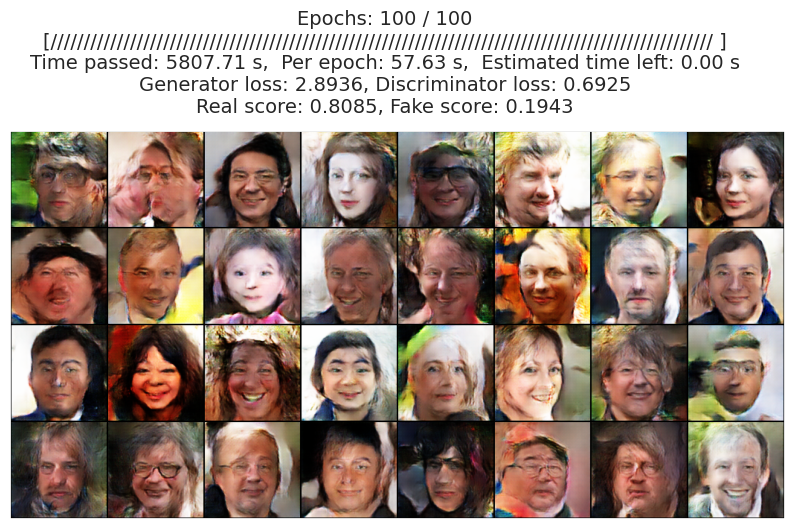

Saving generated-images-0100.png


In [147]:
history = fit(model, criterion, epochs, lr, plot_outputs)

Постройте графики лосса для генератора и дискриминатора. Что вы можете сказать про эти графики?

In [149]:
torch.save(discriminator.state_dict(), f='discr100_1e-4_sl.pth')
torch.save(generator.state_dict(), f='gen100_3e-4_sl.pth')

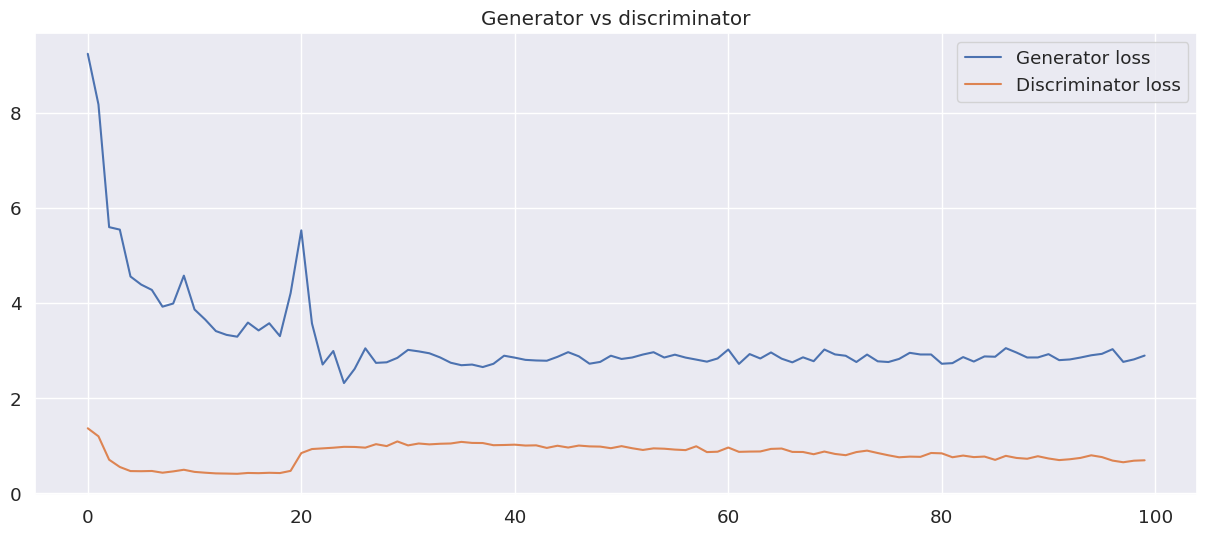

In [150]:
plt.figure(figsize=(15, 6))
plt.plot(history[0], label='Generator loss')
plt.plot(history[1], label='Discriminator loss')
plt.title('Generator vs discriminator')
plt.legend()
plt.show()

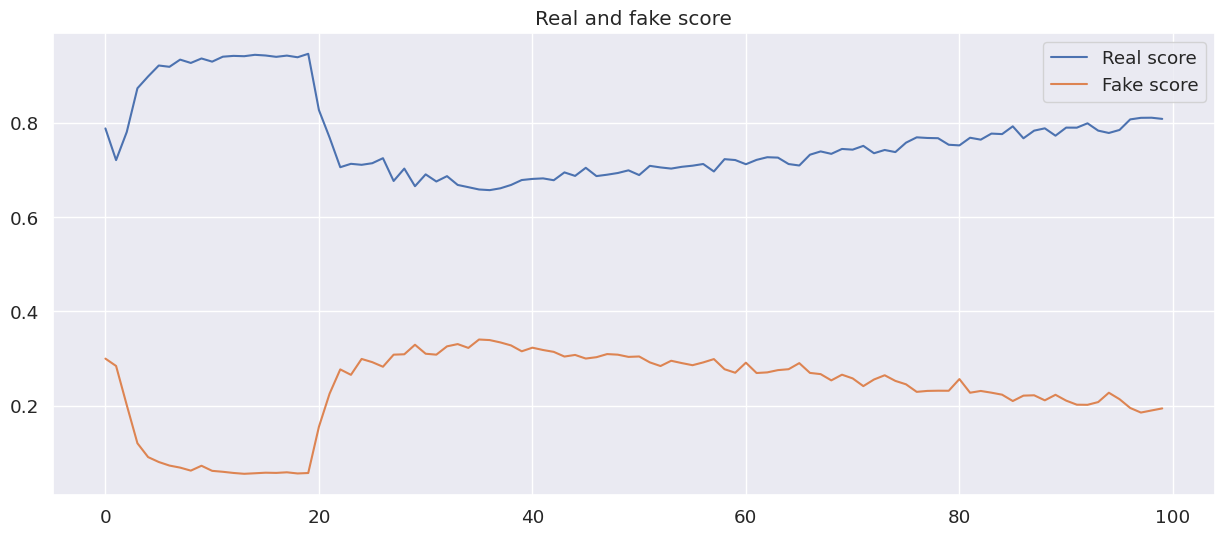

In [151]:
plt.figure(figsize=(15, 6))
plt.plot(history[2], label='Real score')
plt.plot(history[3], label='Fake score')
plt.title('Real and fake score')
plt.legend()
plt.show()

В начале (где-то до 20 эпохи) у генератора получалось очень плохо, дискриминатор спокойно различал фейковые изображения от настоящих. Затем генератор резко что-то понял, и неподготовленному к такому повороту событий дискрминатору стало труднее отличать изображения. Однако со временем дискриминатор начал побеждать в их противостоянии. На самом деле, сложно сказать, что будет происходить дальше. Мне кажется, с ростом количеста эпох качество сгенерированных картинок может еще возрасти. Также из-за soft labels значения лоссов и скоров немного изменены, относительно того, если бы были жесткие метки 0 и 1.

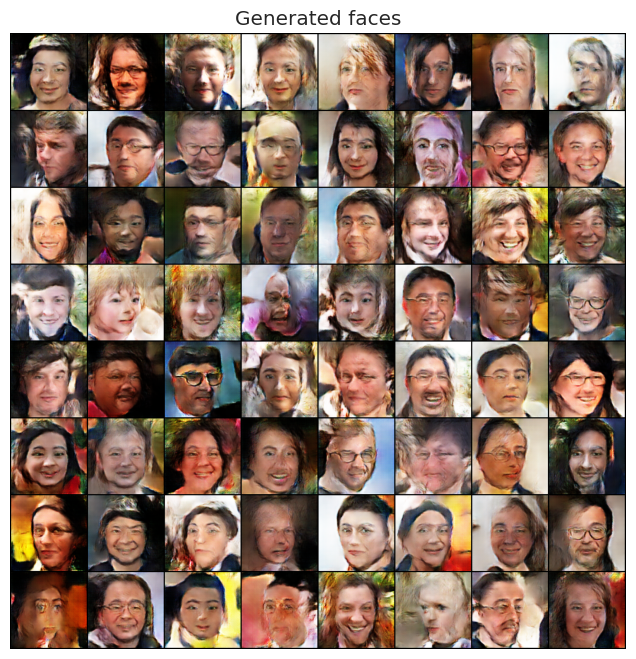

In [173]:
img = cv2.cvtColor(
    cv2.imread('/kaggle/working/generated/generated-images-0100.png'),
    cv2.COLOR_BGR2RGB
)
plt.figure(figsize=(8,8))
plt.imshow(img)
plt.axis('off')
plt.title('Generated faces')
plt.show()

## Часть 3. Генерация изображений (1 балл)

Теперь давайте оценим качество получившихся изображений. Напишите функцию, которая выводит изображения, сгенерированные нашим генератором

Функция была реализована ранее

In [174]:
n_images = 64

fixed_latent2 = torch.randn(n_images, latent_size, 1, 1, device=device)
model["generator"].eval()
with torch.no_grad():
    fake_images = model["generator"](fixed_latent2)

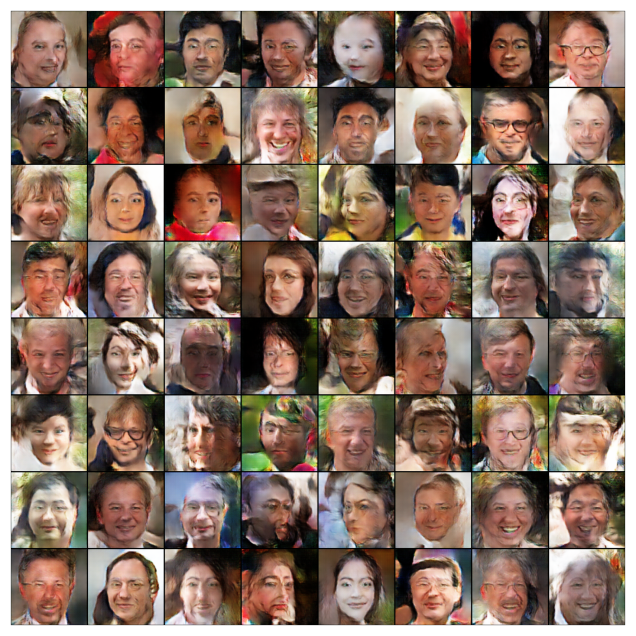

In [175]:
show_images(fake_images.cpu(), n_images)

Как вам качество получившихся изображений?

На самом деле, довольно неплохо. Те же 100 эпох без soft labels и с одинаковым lr'ом давали результаты намного хуже. Но тут все сильно зависит от рандома, поэтому сложно сказать, сильно ли это повлияло.

Некторые картинки прямо вообще хорошие (относительно :)). А еще генератор любит очки)

## Часть 4. Leave-one-out-1-NN classifier accuracy (6 баллов)

### 4.1. Подсчет accuracy (4 балла)

Не всегда бывает удобно оценивать качество сгенерированных картинок глазами. В качестве альтернативы вам предлагается реализовать следующий подход:
  * Сгенерировать столько же фейковых изображений, сколько есть настоящих в обучающей выборке. Присвоить фейковым метку класса 0, настоящим – 1.
  * Построить leave-one-out оценку: обучить 1NN Classifier (`sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)`) предсказывать класс на всех объектах, кроме одного, проверить качество (accuracy) на оставшемся объекте. В этом вам поможет `sklearn.model_selection.LeaveOneOut`

In [69]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import LeaveOneOut

Сначала захотелось глазами посмотреть на нормализованные и ненормализованные изображения, увидеть, точно ли диапазон пикселей от -1 до 1 и от 0 до 1 соответственно, и на что это влияет визуально.

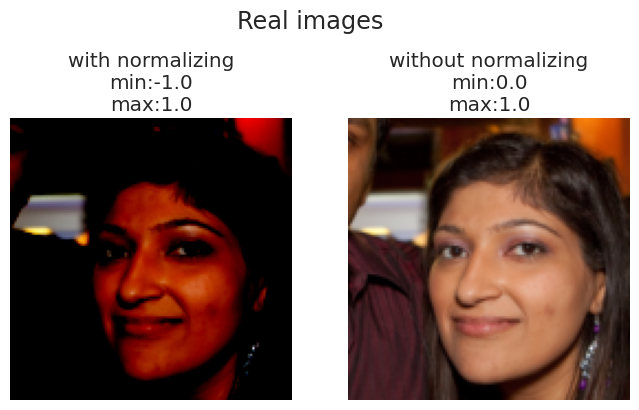

In [176]:
tr = tt.Compose(
        [
            tt.Resize((image_size, image_size)),
            tt.ToImageTensor(),
            tt.ConvertImageDtype(torch.float),
            tt.Normalize(
                 [0.5, 0.5, 0.5],
                 [0.5, 0.5, 0.5],
             ),
        ]
    )
tr2 = tt.Compose(
        [
            tt.Resize((image_size, image_size)),
            tt.ToImageTensor(),
            tt.ConvertImageDtype(torch.float),
        ]
    )
dataset = ImageFolder(root=DATA_DIR, transform=tr)
dataset2 = ImageFolder(root=DATA_DIR, transform=tr2)
fig, axes = plt.subplots(1, 2, figsize=(8, 5))
axes[0].imshow(dataset[1][0].permute(1, 2, 0))
axes[0].axis('off')
axes[0].set_title('with normalizing\n'
                  f'min:{torch.min(dataset[1][0])}\nmax:{torch.max(dataset[1][0])}')
axes[1].imshow(dataset2[1][0].permute(1, 2, 0))
axes[1].axis('off')
axes[1].set_title('without normalizing\n'
                  f'min:{torch.min(dataset2[1][0])}\nmax:{torch.max(dataset2[1][0])}')
plt.suptitle('Real images')
fig.subplots_adjust(top=0.85)
plt.show()

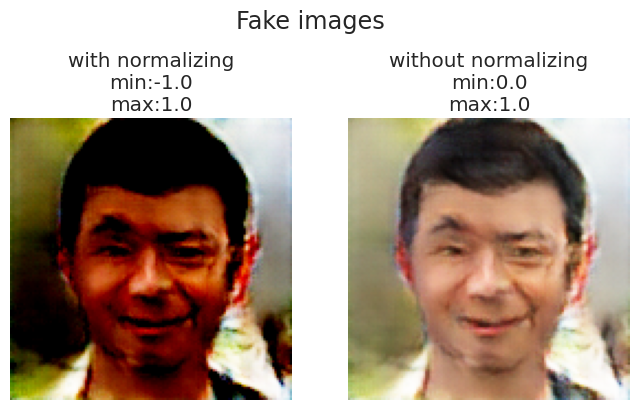

In [212]:
n_images = 1

fixed_latent2 = torch.randn(n_images, latent_size, 1, 1, device=device)
with torch.no_grad():
    fake_image = model["generator"](fixed_latent2).detach().cpu()

fig, axes = plt.subplots(1, 2, figsize=(8, 5))
axes[0].imshow(fake_image[0].permute(1, 2, 0))
axes[0].axis('off')
axes[0].set_title('with normalizing\n'
                  f'min:{torch.min(fake_image[0]):.1f}\nmax:{torch.max(fake_image[0]):.1f}')
axes[1].imshow(denorm(fake_image[0]).permute(1, 2, 0))
axes[1].axis('off')
axes[1].set_title('without normalizing\n'
                  f'min:{torch.min(denorm(fake_image[0])):.1f}\n'
                  f'max:{torch.max(denorm(fake_image[0])):.1f}')
plt.suptitle('Fake images')
fig.subplots_adjust(top=0.85)
plt.show()

Для подачи в KNeighborsClassifier будем использовать не нормализованные изображения (с пикселями в диапазоне от 0 до 1). Для подачи в классификатор и в TSNE придется вытянуть изображения (из (n, 3, 128, 128) в (n, 3 * 128 * 128)).

In [232]:
new_batch_size = 256
new_tr_loader = DataLoader(
    dataset2,
    batch_size=new_batch_size,
    shuffle=False,
    num_workers=os.cpu_count()
)
images_train = torch.tensor([], dtype=torch.float)
for image_batch, _ in tqdm(new_tr_loader, desc='Train dataloader'):
    images_train = torch.cat((images_train, image_batch), dim=0)

Train dataloader:   0%|          | 0/13 [00:00<?, ?it/s]

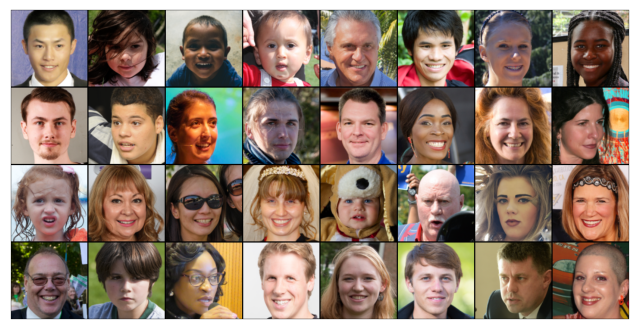

In [234]:
num_imgs = 32
show_images(
    images_train[np.random.randint(0, images_train.shape[0]-1, num_imgs)],
    num_imgs,
    norm=False
)

In [235]:
images_train = images_train.reshape(images_train.shape[0], -1)
print('Images train after reshaping:', images_train.size())

Images train after reshaping: torch.Size([3143, 49152])


In [236]:
# Чтобы сгенерировать такое же количество изображений, как и на трейне
latent_shapes = (len(dataset2) // 128 * [128]) + [len(dataset2) % 128]

In [237]:
generated_images = torch.tensor([], dtype=torch.float).to(device)
for lat_shape in tqdm(latent_shapes, desc='Generating fake images'):
    fixed_latent2 = torch.randn(lat_shape, latent_size, 1, 1, device=device)
    with torch.no_grad():
        fake_images = model["generator"](fixed_latent2).detach()
    generated_images = torch.cat((generated_images, denorm(fake_images)), dim=0)
generated_images = generated_images.cpu()

Generating fake images:   0%|          | 0/25 [00:00<?, ?it/s]

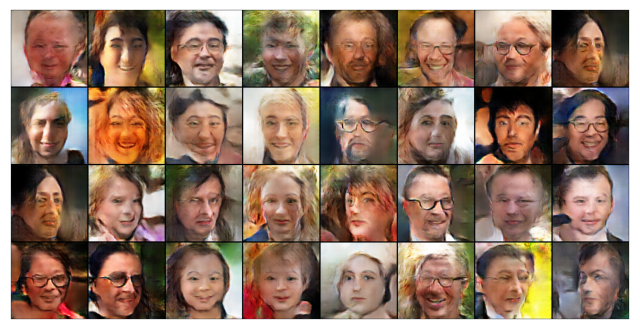

In [240]:
show_images(
    generated_images[np.random.randint(0, generated_images.shape[0], num_imgs)],
    num_imgs,
    norm=False
)

In [241]:
generated_images = generated_images.reshape(generated_images.shape[0], -1)
print('Generated images after reshaping:', generated_images.size())
print(generated_images.size() == images_train.size())

Generated images after reshaping: torch.Size([3143, 49152])
True


In [242]:
print(f'Generated min: {torch.min(generated_images)}, max: {torch.max(generated_images)}')
print(f'Train min: {torch.min(images_train)}, max: {torch.max(images_train)}')

Generated min: 0.0, max: 1.0
Train min: 0.0, max: 1.0


In [243]:
images_train = images_train.numpy()
# Тут немного перемешаем трейн, чтобы были лица разных людей
np.random.shuffle(images_train)

Для обучения KNN возьмем по 1000 реальных и фейковых изображений, потому что если брать все, то процесс длится примерно 2 часа. Для визуализации с помощью TSNE возьмем все изображения (метки классов будут использоваться для визуализации результатов).

In [246]:
images_knn = np.concatenate(
    (
        generated_images.numpy()[:1000],
        images_train[:1000]
    )
)
all_images_tsne = np.concatenate(
    (
        generated_images.numpy(),
        images_train
    )
)
labels_knn = torch.cat((
    torch.zeros(images_knn.shape[0] // 2, dtype=torch.int8),
    torch.ones(images_knn.shape[0] // 2, dtype=torch.int8)
)).numpy()
all_labels_tsne = torch.cat((
    torch.zeros(all_images_tsne.shape[0] // 2, dtype=torch.int8),
    torch.ones(all_images_tsne.shape[0] // 2, dtype=torch.int8)
)).numpy()

In [247]:
print('Images for KNN shape:', images_knn.shape)
print('Labels for KNN shape:', labels_knn.shape)
print('All images shape:', all_images_tsne.shape)
print('All labels shape:', all_labels_tsne.shape)

Images for KNN shape: (2000, 49152)
Labels for KNN shape: (2000,)
All images shape: (6286, 49152)
All labels shape: (6286,)


In [248]:
labels_knn

array([0, 0, 0, ..., 1, 1, 1], dtype=int8)

In [249]:
loo = LeaveOneOut()

total_acc = 0.0

knc = KNeighborsClassifier(n_neighbors=1, n_jobs=-1)

for train_idx, test_idx in tqdm(
    loo.split(images_knn),
    desc='KNN + LOO',
    total=loo.get_n_splits(images_knn)
):
    X_train, X_test = images_knn[train_idx], images_knn[test_idx]
    y_train, y_test = labels_knn[train_idx], labels_knn[test_idx]

    knc.fit(X_train, y_train)

    total_acc += knc.score(X_test, y_test)
    
mean_acc = total_acc / loo.get_n_splits(images_knn)
print('Mean accuracy: ', mean_acc)

KNN + LOO:   0%|          | 0/2000 [00:00<?, ?it/s]

Mean accuracy:  0.686


Что вы можете сказать о получившемся результате? Какой accuracy мы хотели бы получить и почему?

Мы хотели бы получить 0.5 accuracy (то есть результат работы классификатора не лучше простого угадывания, а значит очень трудно отличать реальные и фейковые картинки). Accuracy 0.69, по-моему, довольно неплохой результат. То есть для примерно 30% изображений ближаший сосед (по используемой в KNN метрике) является представителем противоположного класса. Конечно, тут еще можно вспомнить, что мы изображения растягивали в вектор, что могло немного снизить информативность.

### 4.2. Визуализация распределений (2 балла)

Давайте посмотрим на то, насколько похожи распределения настоящих и фейковых изображений. Для этого воспользуйтесь методом, снижающим размерность (к примеру, TSNE) и изобразите на графике разным цветом точки, соответствующие реальным и сгенерированным изображенияи

In [85]:
from sklearn.manifold import TSNE

In [250]:
img_embeddings = TSNE(
    n_components=2,
    random_state=123,
    n_jobs=-1
).fit_transform(all_images_tsne)

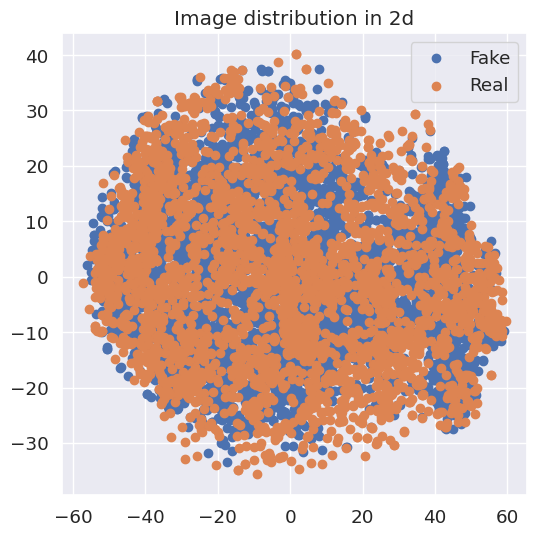

In [251]:
plt.figure(figsize=(6, 6))
for label in np.unique(all_labels_tsne):
    mask = all_labels_tsne == label
    plt.scatter(
        img_embeddings[mask][:, 0],
        img_embeddings[mask][:, 1],
        label= 'Real' if label else 'Fake'
    )
plt.title('Image distribution in 2d')
plt.legend()
plt.show()

Прокомментируйте получившийся результат:

На графике все картинки находятся в +- едином облаке, что говорит о том, что их довольно трудно между собой различить. Конечно, есть еще гиперпараметры у TSNE и, опять же, картинки представлены в виде векторов, но, в целом, картина такая.